In [1]:
# Basic library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import seaborn as sns
from itertools import cycle
Fignum = cycle(range(1,50))

# Data preprocessing
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


# Tune and Develop Model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier 

# Evaluation
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.externals import joblib

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set dataframe display
pd.set_option('display.max_columns', None)  # default = 20
pd.set_option('display.expand_frame_repr', False) # True
pd.set_option('display.max_colwidth', -1) # 50

# Disable python warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('./data/avazu-ctr-prediction/train.csv', nrows=10000)

# Integer boolean mask
Integer_feature_mask = df.dtypes==int
# filter Integer columns using mask and turn it into a list
Integer_cols = df.columns[Integer_feature_mask].tolist()
Integer_cols.remove('click')
Integer_cols

['hour',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [4]:
# train_subset data is first 10K rows of 6+GB set
df = pd.read_csv('./data/avazu-ctr-prediction/train.csv',
                 dtype={i:'category' for i in Integer_cols},
#                  parse_dates=["hour"],
                 nrows=10000)

In [5]:
df.shape

(10000, 24)

0    8294
1    1706
Name: click, dtype: int64


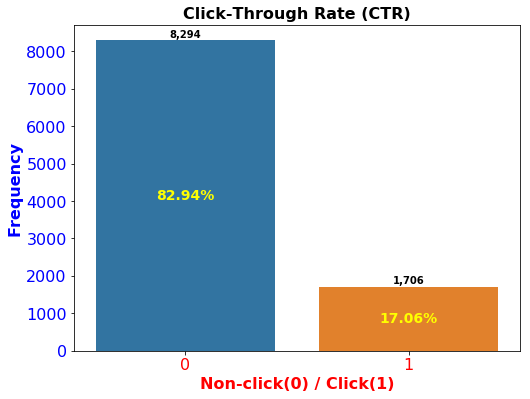

In [6]:
import matplotlib 

# Fill Paramter
fs = 16 # Font size
x_data = df
x_col = 'click' # column to count
x_hue = None # For divide column

matplotlib.rc('xtick', labelsize = fs-2)     
matplotlib.rc('ytick', labelsize = fs-2)

counts = x_data[x_col].value_counts()
max_count = max(counts)
total_count = sum(counts)
print(counts)
fig = plt.figure(figsize= (8,6))
ax = sns.countplot(x = x_col, hue = x_hue, data=x_data, order = counts.iloc[:10].index)
# fig.suptitle('test title', fontsize=12)
ax.set_title('Click-Through Rate (CTR)', fontsize = fs, fontweight='bold' )
ax.set_xlabel('Non-click(0) / Click(1)', color = 'r', fontsize = fs, fontweight='bold')
ax.set_ylabel('Frequency', color = 'b', fontsize = fs, fontweight='bold')
# plt.xticks(rotation=15, color='r', size=16)
plt.xticks(color='r', size=16)
plt.yticks(color='b', size=16)

for i, v in enumerate(counts[:10]):
        ax.text(x = i, y=v + max_count*0.01 , s=f'{v:,}', horizontalalignment='center', color='black', fontweight='bold')
        ax.text(x = i, y= v/2, s=str(f'{v*100/total_count :.2f}')+'%',
                color='yellow', fontweight='bold', size = 14,
                horizontalalignment='center', 
                verticalalignment='center' 
                )

In [14]:
from pprint import pprint
# Print unique value each column which less than 5 unique value
col_list = df.columns.tolist()
exclude_list = []
for i in col_list:
    nuni = df[i].nunique()
    print('\n{} : {}'.format(str(i),nuni))
    if nuni < 5:
        uni = df[i].unique().tolist()
        print('>>> Item Lists: {}'.format(uni))
    if nuni > 1000 or nuni < 3:
        exclude_list.append(i)    
#         pprint(f'{str(i)} Number of Unique Item: {nuni} Item Lists: {uni}')


id : 10000

click : 2
>>> Item Lists: [0, 1]

hour : 1
>>> Item Lists: ['14102100']

C1 : 6

banner_pos : 4
>>> Item Lists: ['0', '1', '4', '5']

site_id : 381

site_domain : 317

site_category : 14

app_id : 313

app_domain : 31

app_category : 14

device_id : 1075

device_ip : 7302

device_model : 1168

device_type : 4
>>> Item Lists: ['1', '0', '4', '5']

device_conn_type : 4
>>> Item Lists: ['2', '0', '3', '5']

C14 : 271

C15 : 4
>>> Item Lists: ['320', '300', '216', '728']

C16 : 5

C17 : 111

C18 : 4
>>> Item Lists: ['0', '3', '2', '1']

C19 : 32

C20 : 108

C21 : 29


In [15]:
exclude_list

['id', 'click', 'hour', 'device_id', 'device_ip', 'device_model']

In [16]:
X = df.drop(exclude_list, axis =1)
y = df['click']

In [17]:
# Get dummies
X_encoded = pd.get_dummies(X, prefix_sep='_', drop_first=True)
# X head
print(len(X_encoded.columns))
X_encoded.head()

1634


,C1_1002,C1_1005,C1_1007,C1_1008,C1_1010,banner_pos_1,banner_pos_4,banner_pos_5,site_id_02d5151c,site_id_02fb33fd,site_id_030440fe,site_id_0338ff60,site_id_03cecb5d,site_id_04773863,site_id_066a0884,site_id_06a0ac14,site_id_070ca277,site_id_081cfb60,site_id_09c3b4c1,site_id_0a647e36,site_id_0a742914,site_id_0aab7161,site_id_0c2fe9d6,site_id_0d0207b0,site_id_0eb72673,site_id_0f30aed6,site_id_10a74e5b,site_id_11944c42,site_id_12fb4121,site_id_13b31263,site_id_147fe840,site_id_14c5faa4,site_id_14ec6216,site_id_15941585,site_id_15a497fe,site_id_15d93b0b,site_id_16c73019,site_id_178a7b89,site_id_17a1026e,site_id_17caea14,site_id_18859862,site_id_19a1e5c0,site_id_1a5c1d83,site_id_1aaa89da,site_id_1b171d6d,site_id_1b4b015f,site_id_1bf0f8d0,site_id_1d6e0bd7,site_id_1df47d50,site_id_1e25e084,site_id_1fbe01fe,site_id_2092875a,site_id_222acd54,site_id_22d080df,site_id_2328ee8e,site_id_2398553f,site_id_239adfaf,site_id_23d99ea0,site_id_240ecdfd,site_id_258442a1,site_id_26fa1946,site_id_29229f8e,site_id_29cfa778,site_id_2a68aa20,site_id_2b1ddb24,site_id_2c4ed2f7,site_id_2d7bacb1,site_id_2e582cf9,site_id_2ee82a0f,site_id_2fb3751e,site_id_2fb424e8,site_id_2fdff0f2,site_id_30cf412d,site_id_325a8a1e,site_id_325dbe14,site_id_3281baa7,site_id_34040f5c,site_id_344bdd17,site_id_34781e41,site_id_34d1d55f,site_id_35584290,site_id_36b1bd1c,site_id_37189abe,site_id_37ecc00c,site_id_38217daf,site_id_383f4a51,site_id_38c202aa,site_id_395fa97c,site_id_39cffaa4,site_id_39d85719,site_id_3a66a5a5,site_id_3af745f2,site_id_3c20a05a,site_id_3c5d765d,site_id_3ce4be5b,site_id_3d88bdd0,site_id_3dbbce24,site_id_3dc2d6de,site_id_3dff2c35,site_id_3e183f99,site_id_3e3abd65,site_id_3e81fcf1,site_id_3fc3d822,site_id_40cd84f1,site_id_41477778,site_id_43402849,site_id_43907498,site_id_43d6df75,site_id_44637516,site_id_44f60771,site_id_45832b51,site_id_45e91bcc,site_id_461f4ff6,site_id_469fd1ad,site_id_46aba789,site_id_47d1a0f2,site_id_487c858e,site_id_48c42b43,site_id_4a02380f,site_id_4b0f0061,site_id_4bf5bbe2,site_id_4dd0a958,site_id_4ec231b7,site_id_4fd4e711,site_id_5014edea,site_id_5070e53c,site_id_5114c672,site_id_517b8671,site_id_518d6168,site_id_51a8ceda,site_id_529a2583,site_id_52b42525,site_id_52c67a67,site_id_5380ca88,site_id_543a539e,site_id_54e6fb06,site_id_56c2fd20,site_id_572b1ee1,site_id_57fe1b20,site_id_5a83611c,site_id_5abb07e8,site_id_5b08c53b,site_id_5b4d2eda,site_id_5b787406,site_id_5b904c3a,site_id_5bcf81a2,site_id_5c6f356c,site_id_5eb1d12d,site_id_5ee41ff2,site_id_609ab969,site_id_60efd545,site_id_61742004,site_id_61a8c644,site_id_621fc84d,site_id_6256f5b4,site_id_636f3a62,site_id_6399eda6,site_id_63bd7850,site_id_6423a528,site_id_653f65e4,site_id_67ee2827,site_id_686546d3,site_id_69bc54b5,site_id_6b175d24,site_id_6bbe137e,site_id_6bdcda77,site_id_6c5b482c,site_id_6c7e709c,site_id_6ec06dbd,site_id_6f1058d5,site_id_6f34dd1d,site_id_7034b859,site_id_727e79e2,site_id_7294ea0f,site_id_72a56356,site_id_7443a906,site_id_74fb2abe,site_id_7549fe4f,site_id_75f43c5a,site_id_76274f48,site_id_763a42b5,site_id_7697ed3e,site_id_77bfdd7b,site_id_78b4322c,site_id_790c9243,site_id_791b5571,site_id_79df8c62,site_id_7a34d501,site_id_7aec40a2,site_id_7b86de5b,site_id_7c6576be,site_id_7cd8eead,site_id_7dd19f44,site_id_7ed11bd1,site_id_7f05516e,site_id_7f4b0183,site_id_7fa5a4d1,site_id_801dfefb,site_id_803ffc86,site_id_80c7456b,site_id_81894a37,site_id_81bf62aa,site_id_83337efb,site_id_8342c1ae,site_id_83a0ad1a,site_id_84a56636,site_id_84bfe282,site_id_84c7ba46,site_id_856e6d3f,site_id_85f751fd,site_id_88154ade,site_id_887a4754,site_id_8907c166,site_id_897f88f1,site_id_89a490f5,site_id_8b6e6813,site_id_8bc5ccf8,site_id_8c788ce9,site_id_8cbacf0b,site_id_8d7e1373,site_id_8e983a36,site_id_8f4a7b0c,site_id_8f51bf3a,site_id_8f85b7f5,site_id_8fbe746d,site_id_8fda644b,site_id_90650879,site_id_915a59a3,site_id_92504276,site_id_929d2171,site_id_92c7cbe7,site_id_92d82c17,site_id_92fa1eaf,site_id_930c2840,site_id_93377b07,site_id_93de26ae,site_id_93eaba74,site_id_94440a23,site_id_94

In [18]:
def down_sampling(X,y):                      
    rus = RandomUnderSampler(random_state=7)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

In [19]:
# X_dn, y_dn = down_sampling(X, y)
X_dn, y_dn = down_sampling(X_encoded, y)

In [20]:
X_dn.shape

(3412, 1634)

In [21]:
list(map(int,np.logspace(1,5,10, base=5)))

[5, 10, 20, 42, 87, 178, 365, 747, 1528, 3125]

In [30]:
np.array([20, 50, 100])

array([ 20,  50, 100])

In [23]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
def RFC_HPTune(X, y, verbose = 0):
    """
    Purpose
    ----------
    Choosing a set of optimal hyperparameters for a Random Forests Classifier

    Parameters
    ----------
    X: Data set with all feature or predictor
    y: Data set with Class
    verbose: 0 mean not show summary of tuning
             1 mean show summary of tuning
    Returns:
    ----------
    Returns grid search model of Random Forests Classifier with tuned hyperparameter
    """    
    
    fit_rf = RandomForestClassifier(n_estimators = n_est, max_features = max_fea, random_state = rs)
    
    pipeline = Pipeline([('clf',fit_rf)])
    
    param_grid = {'clf__max_depth': [20], #list(map(int,np.logspace(1,5,10, base=5))), # np.arange(4,20),
                  #'clf__bootstrap': [True, False],
                  #'clf__max_features': ['auto', 'sqrt', 'log2', None],
#                   'clf__criterion': ['gini', 'entropy'],
                  'clf__n_estimators': [100], #np.array([20, 50, 100]), 
                  #'clf__min_samples_leaf':(1,2),                 
                  #'clf__min_samples_split':(2,3) 
                 }

    
    gs = GridSearchCV( estimator = pipeline, 
                       param_grid = param_grid,
                       refit = True,
                       scoring = score_param,
                       cv = cv,
                       n_jobs = -1, 
                       iid = True)   
    if verbose == 1:
        start = time()
        gs.fit(X,y)
        print("GridSearchCV took %.2f seconds for %d candidate parameter settings with %d estimator and select %d features per node"
              % (time() - start, len(gs.cv_results_['params']), n_est, max_fea))

    elif verbose == 0:
        gs.fit(X,y)
    
    return gs

## Set parameter for tuning

In [65]:
score_param = 'accuracy'
LOO = LeaveOneOut()
rs = 7  # random state number
n_est = 20 # number of estimator
max_fea = 20 # number of feature using in each estimator
cv = 5

In [33]:
X_dn

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [34]:
pd.DataFrame(y_dn, columns=['click'])['click'].value_counts()

1    1706
0    1706
Name: click, dtype: int64

In [81]:
print('Hyper parameter tuning in 10,000 sampling ')
print('Random Forest Classifier is tuning......')
gs_RFC = RFC_HPTune(X_dn, y_dn, verbose = 1)

Hyper parameter tuning in 10,000 sampling 
Random Forest Classifier is tuning......
GridSearchCV took 30.87 seconds for 4 candidate parameter settings with 20 estimator and select 20 features per node


In [56]:
# load the model from disk

filename_grid = './Model_report/gs_RFC_1.sav'
gs_RFC_1 = joblib.load(filename_grid)

filename_grid = './Model_report/gs_RFC_2.sav'
gs_RFC_2 = joblib.load(filename_grid)

# Evaluation Model

In [36]:
# Make a model summary report
def model_report(X_test,y_test,GridSearchCV_List,model_func):

    model_list = []
    accuracy_list = []
    balanced_acc_list = []
    auc_list = []
    cm_list = []
    recall_list = []
    precision_list = []
    ap_list = []
    f1_list = []
    best_params_list = []
    

    for i,j in enumerate(GridSearchCV_List):
        locals()[j] = model_func[i]
        
        if isinstance(model_func[i], 
                      (sklearn.model_selection._search.RandomizedSearchCV,
                       sklearn.model_selection.GridSearchCV)):            
            y_pred = eval(j+'.best_estimator_.predict(X_test)')
            P_true = eval(j+'.predict_proba(X_test)[:, 1]')
            best_params = eval(j+'.best_params_')
            best_params_list.append(best_params)
        else:
            y_pred = eval(j+'.predict(X_test)')
            P_true = eval(j+'.predict_proba(X_test)[:, 1]')
             
        model_name = j
        TP, FN, FP, TN = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()
        
        Accuracy = round(accuracy_score(y_test, y_pred), 2)
        bal_acc = round(balanced_accuracy_score(y_test, y_pred),2)
        auc = round(roc_auc_score(y_test, P_true), 2)
        cm = dict(TP=TP, FP=FP, FN=FN, TN=TN)
        Recall = round(recall_score(y_test, y_pred, average='binary'), 2)
        Precision = round(precision_score(y_test, y_pred, average='binary'), 2)
        ap = round(average_precision_score(y_test, P_true, pos_label=1), 2)
        F1_score = round(f1_score(y_test, y_pred,average='binary'), 2)
        
        
        model_list.append(model_name)
        accuracy_list.append(Accuracy)
        balanced_acc_list.append(bal_acc)
        auc_list.append(auc)
        cm_list.append(cm)
        recall_list.append(Recall)
        precision_list.append(Precision)
        ap_list.append(ap)
        f1_list.append(F1_score)
        
        

    report = dict(Model = model_list,
                  Accuracy = accuracy_list,
                  Balanced_Accuracy = balanced_acc_list,
                  AUC = auc_list,
                  Confusion_Matrix = cm_list,
                  Recall = recall_list,
                  Precision = precision_list,
                  Average_Precision = ap_list,
                  F1_score = f1_list,
                  Best_Parameters = best_params_list 
                 )
    
    df_report = pd.DataFrame.from_dict(report)
    pd.set_option('display.max_colwidth', -1)
    
    return df_report

In [60]:
def cvt_type(df, col_list, dtype = 'category'):
    for col in col_list:
        df[col] = df[col].astype('category')
    return df


In [62]:
# train_subset data is first 50K rows of 6+GB set
df_1 = pd.read_csv('./data/avazu-ctr-prediction/train.csv',
                 dtype={i:'category' for i in Integer_cols},
#                  parse_dates=["hour"],
                 nrows=50000)

all_column = df_1.drop(['id','click','hour'], axis =1).columns.tolist()
df_1 = cvt_type(df_1, col_list=all_column)

X_1 = df_1.drop(exclude_list, axis =1)
y_1 = df_1['click']

# Get dummies
X_encoded_1 = pd.get_dummies(X_1, prefix_sep='_', drop_first=True)
# X head
print(len(X_encoded_1.columns))
X_dn_1, y_dn_1 = down_sampling(X_encoded_1, y_1)

2647


In [63]:
GridSearchCV_List = ['gs_RFC_1']
model_func = [gs_RFC_1]

model_report(X_dn_1, y_dn_1, GridSearchCV_List, model_func)

,Model,Accuracy,Balanced_Accuracy,AUC,Confusion_Matrix,Recall,Precision,Average_Precision,F1_score,Best_Parameters
0,gs_RFC_1,0.69,0.69,0.76,"{'TP': 6957, 'FP': 3634, 'FN': 1807, 'TN': 5130}",0.79,0.66,0.74,0.72,"{'clf__max_features': 'auto', 'clf__n_estimators': 100, 'clf__criterion': 'entropy', 'clf__max_depth': 20}"


In [83]:
print(len(X_encoded.columns))

1634


In [59]:
GridSearchCV_List = ['gs_RFC_2']
model_func = [gs_RFC_2]

model_report(X_dn, y_dn, GridSearchCV_List, model_func)

,Model,Accuracy,Balanced_Accuracy,AUC,Confusion_Matrix,Recall,Precision,Average_Precision,F1_score,Best_Parameters
0,gs_RFC_2,0.73,0.73,0.81,"{'TP': 1373, 'FP': 584, 'FN': 333, 'TN': 1122}",0.8,0.7,0.8,0.75,"{'clf__max_depth': 20, 'clf__n_estimators': 100}"


In [82]:
GridSearchCV_List = ['gs_RFC']
model_func = [gs_RFC]

model_report(X_dn, y_dn, GridSearchCV_List, model_func)

,Model,Accuracy,Balanced_Accuracy,AUC,Confusion_Matrix,Recall,Precision,Average_Precision,F1_score,Best_Parameters
0,gs_RFC,0.73,0.73,0.81,"{'TP': 1384, 'FP': 594, 'FN': 322, 'TN': 1112}",0.81,0.7,0.8,0.75,"{'clf__max_depth': 20, 'clf__n_estimators': 250}"


In [83]:
# Variable Importance 

def variable_importance_plot(gs_model, feat_labels, title_name = ''):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feat_labels list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    gs_model:   Model from GridSearchCV with already be tuned. We will use it
                to extract the Random Forests estimator for finding `importance` and `indices`
                importance_desc: Array returned from feature_importances_ for CART
                                 models organized in descending order
                indices: Organized index of dataframe from largest to smallest
                         based on feature_importances_                
    feat_labels: Name of features
    title_name: For naming a title.
    
    Returns:
    ----------
    Returns variable importance plot in descending order with figure and full tittle name of figure
    """
    n_fea = len(feat_labels)
    index = np.arange(n_fea)
    
    fit_rf = gs_model.best_estimator_[0]
    importance = fit_rf.feature_importances_
    indices = np.argsort(importance)[::-1]

    importance_desc = sorted(importance)
    max_imp = max(importance_desc)
    feature_space = []
    for i in range(n_fea-1, -1, -1):
        feature_space.append(feat_labels[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    title = 'Figure '+ str(next(Fignum)) +' : Feature importances for Random Forest Classifier\n'+ title_name
    plt.title(title)
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space)

    plt.ylim(-1, n_fea)
    plt.xlim(0, max_imp*1.1)
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')
    
    for i, v in enumerate(importance_desc):
        ax.text(v + max_imp*0.02, i + max_imp*0.01, '%.4f'%(v), color='#875FDB', fontweight='bold')

    plt.show()
    plt.close()
    return fig, title

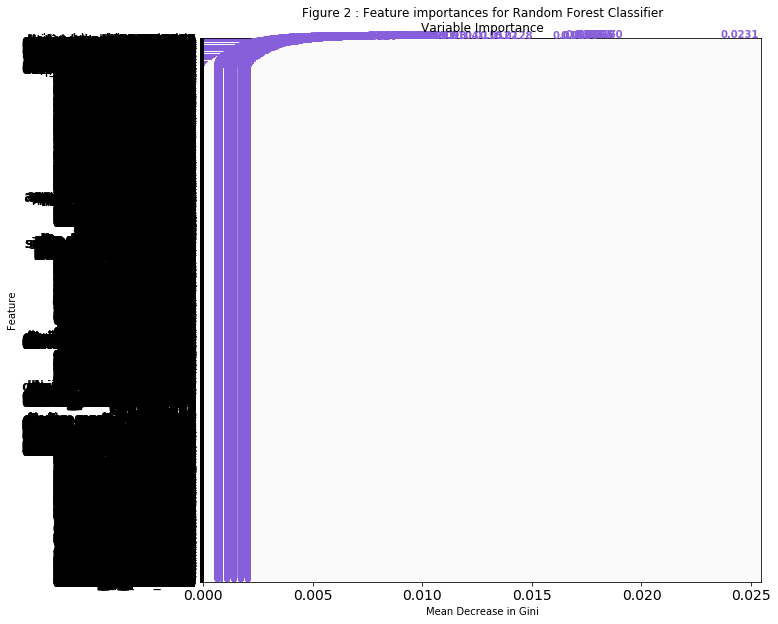

In [85]:
feat_labels = X_encoded.columns.tolist()

fig, title = variable_importance_plot(gs_RFC, feat_labels, title_name = 'Variable Importance')
# figure_list.append(fig)
# figure_name.append(title)Parin Kittipongdaja

In [42]:
feat_labels = X_encoded.columns.tolist()

n_fea = len(feat_labels)
index = np.arange(n_fea)
fit_rf = gs_RFC.best_estimator_[0]
importance = fit_rf.feature_importances_
indices = np.argsort(importance)[::-1]

importance_desc = sorted(importance)
max_imp = max(importance_desc)
feature_space = []
for i in range(n_fea-1, -1, -1):
    feature_space.append(feat_labels[indices[i]])

In [231]:
index[-20:]
# importance_desc[-20:]
# feature_space[-20:]
# index[:20]
# index[:-20:-1]
min(indices)
# indices[-1]
feat_labels[indices[0]]
# feat_labels[min(indices)]

'C14_21611'

In [199]:
indices

array([10827, 10944, 10941, ...,  7265,  7264,     0])

In [207]:
importance

array([0.00000000e+00, 1.12263534e-06, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [202]:
np.argsort(importance)

array([    0,  7264,  7265, ..., 10941, 10944, 10827])

In [39]:
# Variable Importance 

def variable_importance_plot_2(gs_model, feat_labels, title_name = ''):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feat_labels list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    gs_model:   Model from GridSearchCV with already be tuned. We will use it
                to extract the Random Forests estimator for finding `importance` and `indices`
                importance_desc: Array returned from feature_importances_ for CART
                                 models organized in descending order
                indices: Organized index of dataframe from largest to smallest
                         based on feature_importances_                
    feat_labels: Name of features
    title_name: For naming a title.
    
    Returns:
    ----------
    Returns variable importance plot in descending order with figure and full tittle name of figure
    """
    top = 40
    n_fea = len(feat_labels)
    index = np.arange(n_fea)
    
    fit_rf = gs_model.best_estimator_[0]
    importance = fit_rf.feature_importances_
    indices = np.argsort(importance)[::-1]

    importance_ascen = sorted(importance)
    max_imp = max(importance_ascen)
    feature_space = []
    for i in range(n_fea-1, -1, -1):
        feature_space.append(feat_labels[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    title = 'Figure '+ str(next(Fignum)) +' : Feature importances for Random Forest Classifier\n'+ title_name
    plt.title(title)
    plt.barh(index[:top],
         importance_ascen[-top:],
         align="center",
         color = '#875FDB')
    plt.yticks(index[:top],
           feature_space[-top:])

    plt.ylim(-1, top)
    plt.xlim(0, max_imp*1.1)
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')
    
    for i, v in enumerate(importance_ascen[-top:]):
        ax.text(v + max_imp*0.02, i + max_imp*0.01, '%.4f'%(v), color='#875FDB', fontweight='bold')

    plt.show()
    plt.close()
    return fig, title

In [137]:
top = 200
feature_dict = {}
RFC_Classifier = gs_RFC_2

feat_labels = X_encoded.columns.tolist()

n_fea = len(feat_labels)
index = np.arange(n_fea)
fit_rf = RFC_Classifier.best_estimator_[0]
importance = fit_rf.feature_importances_
indices = np.argsort(importance)[::-1]

importance_desc = sorted(importance)
max_imp = max(importance_desc)
feature_space = []
for i in range(n_fea-1, -1, -1):
    feature_space.append(feat_labels[indices[i]])

Sum_diff = 0
for i, j in zip(feature_space[-top:],importance_desc[-top:]):
    print(i.ljust(25), '{:.2f}%'.format(j*100))
    feature_dict[i] = j
    Sum_diff += j*100

print('Total percent','{:.2f}%'.format(Sum_diff))

app_id_6fc85e22           0.09%
device_type_5             0.09%
C17_2227                  0.09%
site_domain_c4342784      0.09%
site_id_9a977531          0.09%
app_id_8c0dcd5a           0.09%
C20_100221                0.09%
site_domain_759d1c56      0.09%
C20_100055                0.09%
C20_100079                0.09%
C14_1276                  0.09%
site_id_cbb01868          0.10%
C17_2495                  0.10%
site_id_763a42b5          0.10%
app_id_89bdfe24           0.10%
C17_2306                  0.10%
app_id_5e3f096f           0.10%
C14_16685                 0.10%
C20_100019                0.10%
C17_1248                  0.10%
C14_21300                 0.10%
site_category_335d28a8    0.10%
C17_1863                  0.10%
site_domain_9166c161      0.10%
app_id_9c13b419           0.10%
C20_100106                0.10%
app_domain_5c5a694b       0.10%
C14_20633                 0.10%
site_id_38217daf          0.11%
C17_2162                  0.11%
app_id_c0c5eb49           0.11%
C17_1955

In [54]:
feature_dict.keys()

dict_keys(['C17_2333', 'site_domain_7687a86e', 'site_id_d9750ee7', 'C21_33', 'banner_pos_1', 'C15_320', 'site_domain_98572c79', 'C20_100084', 'device_conn_type_2', 'C17_2161', 'site_domain_c7ca3108', 'C17_1993', 'site_id_543a539e', 'C21_157', 'C18_2'])

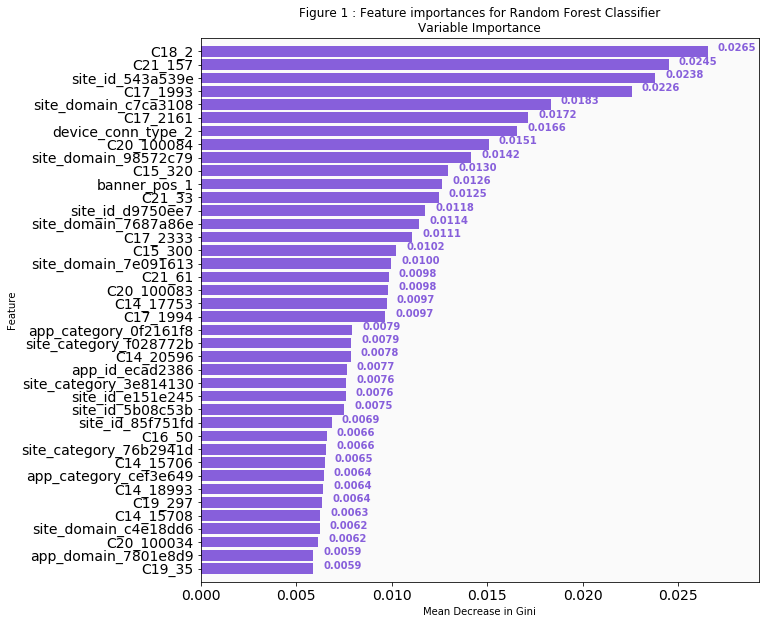

In [41]:
feat_labels = X_encoded.columns.tolist()

fig_2, title_2 = variable_importance_plot_2(gs_RFC, feat_labels, title_name = 'Variable Importance')
# figure_list.append(fig)
# figure_name.append(title)Parin Kittipongdaja

In [96]:
sum(importance_desc)

1.0000000000000004

In [138]:
top = 200
feature_dict_1 = {}
RFC_Classifier = gs_RFC_1

feat_labels = X_encoded_1.columns.tolist()

n_fea = len(feat_labels)
index = np.arange(n_fea)
fit_rf = RFC_Classifier.best_estimator_[0]
importance = fit_rf.feature_importances_
indices = np.argsort(importance)[::-1]

importance_desc = sorted(importance)
max_imp = max(importance_desc)
feature_space = []
for i in range(n_fea-1, -1, -1):
    feature_space.append(feat_labels[indices[i]])

Sum_diff = 0    
for i, j in zip(feature_space[-top:],importance_desc[-top:]):
    print(i.ljust(25), '{:.2f}%'.format(j*100))
    feature_dict_1[i] = j
    Sum_diff += j*100

print('Total percent','{:.2f}%'.format(Sum_diff))

site_id_6256f5b4          0.07%
C20_100233                0.07%
site_id_da79c793          0.07%
site_domain_67cf42d6      0.07%
C14_21300                 0.07%
C14_17212                 0.07%
site_domain_28f93029      0.07%
C20_100200                0.07%
C20_100193                0.07%
C19_167                   0.07%
app_id_8c0dcd5a           0.07%
app_id_e8937587           0.07%
C20_100065                0.07%
C20_100199                0.08%
site_domain_7256c623      0.08%
site_id_e8f79e60          0.08%
C17_2162                  0.08%
C14_19772                 0.08%
C20_100194                0.08%
site_domain_f7570339      0.08%
C21_13                    0.08%
app_id_be7c618d           0.08%
app_id_53de0284           0.09%
site_id_d1a51189          0.09%
C20_100060                0.09%
site_category_335d28a8    0.09%
C1_1010                   0.09%
app_id_95827a92           0.09%
C14_16859                 0.09%
site_domain_d262cf1e      0.09%
C14_16858                 0.09%
site_dom

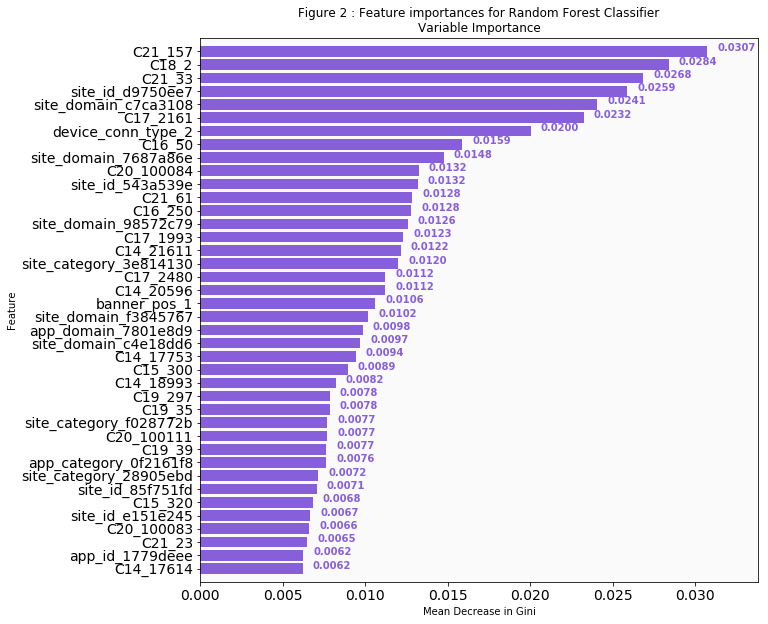

In [88]:
fig_1, title_1 = variable_importance_plot_2(gs_RFC_1, feat_labels, title_name = 'Variable Importance')

In [139]:
fea_set1 = set(feature_dict_1.keys())
fea_set2 = set(feature_dict.keys())

In [140]:
fea_sec = fea_set1.intersection(fea_set2)

In [141]:
print(len(fea_sec))
sorted(list(fea_sec))

150


['C14_15699',
 'C14_15701',
 'C14_15702',
 'C14_15703',
 'C14_15704',
 'C14_15705',
 'C14_15706',
 'C14_15707',
 'C14_15708',
 'C14_17614',
 'C14_17653',
 'C14_17654',
 'C14_17753',
 'C14_18993',
 'C14_19015',
 'C14_19016',
 'C14_19665',
 'C14_19743',
 'C14_20352',
 'C14_20362',
 'C14_20366',
 'C14_20596',
 'C14_20632',
 'C14_20633',
 'C14_21300',
 'C14_21611',
 'C14_21665',
 'C15_300',
 'C15_320',
 'C16_50',
 'C17_1722',
 'C17_1955',
 'C17_1993',
 'C17_1994',
 'C17_2161',
 'C17_2162',
 'C17_2227',
 'C17_2253',
 'C17_2264',
 'C17_2333',
 'C17_2374',
 'C17_2446',
 'C17_2480',
 'C17_2493',
 'C18_2',
 'C18_3',
 'C19_163',
 'C19_167',
 'C19_297',
 'C19_303',
 'C19_35',
 'C19_39',
 'C19_427',
 'C1_1002',
 'C1_1005',
 'C1_1010',
 'C20_100000',
 'C20_100034',
 'C20_100048',
 'C20_100050',
 'C20_100074',
 'C20_100075',
 'C20_100077',
 'C20_100079',
 'C20_100081',
 'C20_100083',
 'C20_100084',
 'C20_100105',
 'C20_100111',
 'C20_100119',
 'C20_100128',
 'C20_100130',
 'C20_100131',
 'C20_100148

In [144]:
final_fea_dict = {}
val_list = []
temp = ('_').join(sorted(list(fea_sec))[0].split('_')[:-1])
for fea in sorted(list(fea_sec)):
    fea_nam, fea_val = ('_').join(fea.split('_')[:-1]), fea.split('_')[-1]
    if fea_nam == temp:
        val_list.append(fea_val)
    else:
        final_fea_dict[temp] = val_list
        val_list = []
        val_list.append(fea_val)
    temp = fea_nam
    
    
# print('Unique Feature',len(set([i[0] for i in final_fea_list])))
print(final_fea_dict)

{'C14': ['15699', '15701', '15702', '15703', '15704', '15705', '15706', '15707', '15708', '17614', '17653', '17654', '17753', '18993', '19015', '19016', '19665', '19743', '20352', '20362', '20366', '20596', '20632', '20633', '21300', '21611', '21665'], 'C15': ['300', '320'], 'C16': ['50'], 'C17': ['1722', '1955', '1993', '1994', '2161', '2162', '2227', '2253', '2264', '2333', '2374', '2446', '2480', '2493'], 'C18': ['2', '3'], 'C19': ['163', '167', '297', '303', '35', '39', '427'], 'C1': ['1002', '1005', '1010'], 'C20': ['100000', '100034', '100048', '100050', '100074', '100075', '100077', '100079', '100081', '100083', '100084', '100105', '100111', '100119', '100128', '100130', '100131', '100148', '100188', '100210', '100228'], 'C21': ['117', '13', '15', '157', '23', '32', '33', '52', '61', '79'], 'app_category': ['0f2161f8', 'cef3e649', 'f95efa07'], 'app_domain': ['2347f47a', '5c5a694b', '7801e8d9', '82e27996', 'd9b5648e'], 'app_id': ['1779deee', '5e3f096f', '89bdfe24', '8c0dcd5a', '9

In [143]:
final_fea_list = []
for fea in sorted(list(fea_sec)):
    fea_nam, fea_val = ('_').join(fea.split('_')[:-1]), fea.split('_')[-1]
    final_fea_list.append((fea_nam, fea_val))
    
print('Unique Feature',len(set([i[0] for i in final_fea_list])))
final_fea_list

Unique Feature 18


[('C14', '15699'),
 ('C14', '15701'),
 ('C14', '15702'),
 ('C14', '15703'),
 ('C14', '15704'),
 ('C14', '15705'),
 ('C14', '15706'),
 ('C14', '15707'),
 ('C14', '15708'),
 ('C14', '17614'),
 ('C14', '17653'),
 ('C14', '17654'),
 ('C14', '17753'),
 ('C14', '18993'),
 ('C14', '19015'),
 ('C14', '19016'),
 ('C14', '19665'),
 ('C14', '19743'),
 ('C14', '20352'),
 ('C14', '20362'),
 ('C14', '20366'),
 ('C14', '20596'),
 ('C14', '20632'),
 ('C14', '20633'),
 ('C14', '21300'),
 ('C14', '21611'),
 ('C14', '21665'),
 ('C15', '300'),
 ('C15', '320'),
 ('C16', '50'),
 ('C17', '1722'),
 ('C17', '1955'),
 ('C17', '1993'),
 ('C17', '1994'),
 ('C17', '2161'),
 ('C17', '2162'),
 ('C17', '2227'),
 ('C17', '2253'),
 ('C17', '2264'),
 ('C17', '2333'),
 ('C17', '2374'),
 ('C17', '2446'),
 ('C17', '2480'),
 ('C17', '2493'),
 ('C18', '2'),
 ('C18', '3'),
 ('C19', '163'),
 ('C19', '167'),
 ('C19', '297'),
 ('C19', '303'),
 ('C19', '35'),
 ('C19', '39'),
 ('C19', '427'),
 ('C1', '1002'),
 ('C1', '1005'),
 ('C

'C14'

# Comprehension of np.argsort

In [221]:
test_list = np.array([99,1,66,65,20,34,9,8,7,2])

In [229]:
b = np.argsort(test_list)
print(b)
c = np.zeros(len(b), dtype = int) 
for i in range(0, len(b)): 
    print(i,b[i],test_list[b[i]] )
    c[i]= test_list[b[i]] 
print('Sorted array->', c) 

[1 9 8 7 6 4 5 3 2 0]
0 1 1
1 9 2
2 8 7
3 7 8
4 6 9
5 4 20
6 5 34
7 3 65
8 2 66
9 0 99
Sorted array-> [ 1  2  7  8  9 20 34 65 66 99]


In [223]:
# https://www.geeksforgeeks.org/sort-sorteda-np-argsorta-np-lexsortb-python/
# np.argsort(a)
# (i) Returns the indices that would sort an array
# (ii) Return type is numpy array
# (iii) Occupies space as a new array of sorted indices is returned

# Python code to demonstrate working of np.argsort 
import numpy as np 
  
# Numpy array created 
a = np.array([9, 3, 1, 7, 4, 3, 6]) 
  
# unsorted array print 
print('Original array:\n', a) 
  
# Sort array indices 
b = np.argsort(a) 
print('Sorted indices of original array->', b) 
  
# To get sorted array using sorted indices 
# c is temp array created of same len as of b 
c = np.zeros(len(b), dtype = int) 
for i in range(0, len(b)): 
    c[i]= a[b[i]] 
print('Sorted array->', c) 

Original array:
 [9 3 1 7 4 3 6]
Sorted indices of original array-> [2 1 5 4 6 3 0]
Sorted array-> [1 3 3 4 6 7 9]
